# HardnessMDL: Instance Hardness Measures

In [1]:
import os
import sys

path_to_research = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

if path_to_research not in sys.path:
    sys.path.insert(0, path_to_research)

print(f"sys.path: {path_to_research}")

sys.path: /home/emanu/ubuntu/ita/HardnessMDL/research


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


In [3]:
def create_folder_plots(folder_path: str, num_datasets: int = 4):
  fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
  fig.suptitle(f'Scatter Plots of {folder_path}')
  
  for i in range(num_datasets):
    df = pd.read_csv(f"{folder_path}test{i+1}.csv")
    sns.scatterplot(ax=axes[i], data=df, x='X', y='Y', hue='class')
    axes[i].set_title(f'DataFrame {i+1}')
  
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
  plt.show()



def transform_dl_string_to_columns(df: pd.DataFrame) -> pd.DataFrame: 
    df_copy = df.copy() # without side-effects

    df_copy['is_error'] = (df_copy['true_label'] != df_copy['label']).astype(int)
    
    df_copy["description_lengths_list"] = df_copy["description_lengths_unnormalized"].apply(
        lambda x: [float(i) for i in x.strip("[]").split(" ") if i]
    )

    description_lengths_columns = pd.DataFrame(
        df_copy["description_lengths_list"].tolist(),
        columns=[f"L_{i}" for i in range(len(df_copy["description_lengths_list"].iloc[0]))],
        index=df_copy.index
    )

    return pd.concat([df_copy.drop(columns=["description_lengths_list"]), description_lengths_columns], axis=1)


In [4]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

def compute_hardness_measures(df):
    """
    Calculates a suite of instance hardness measures based on the model's
    description length (L_*) outputs.

    All measures are standardized to [0, 1], where 0.0 is easy and 1.0 is hard.
    """
    l_cols = [col for col in df.columns if col.startswith('L_')]
    n_classes = len(l_cols)
    
    def row_hardness(row):
        description_lengths = np.array([row[col] for col in l_cols])
        true_label_idx = int(row['true_label'])

        epsilon = 1e-9
        description_lengths[description_lengths <= 0] = epsilon
        
        dl_true = description_lengths[true_label_idx]
        other_dls = np.delete(description_lengths, true_label_idx)
        dl_range = np.max(description_lengths) - np.min(description_lengths)
        
        r_min = min(1.0, dl_true / (np.min(other_dls) + epsilon))
        r_med = min(1.0, dl_true / (np.mean(other_dls) + epsilon))
        rel_pos = (dl_true - np.min(description_lengths)) / (dl_range + epsilon)

        
        probs = np.exp(-(description_lengths - np.min(description_lengths)))
        probs /= np.sum(probs)
        
        pseudo_prob = 1.0 - probs[true_label_idx]

        max_entropy = np.log2(n_classes) if n_classes > 1 else 1.0
        norm_entropy = entropy(probs, base=2) / (max_entropy + epsilon)
        
        sorted_dls = np.sort(description_lengths)
        if len(sorted_dls) > 1:
            margin = sorted_dls[1] - sorted_dls[0]
            description_lenght_margin = 1.0 - (margin / (np.sum(sorted_dls) + epsilon))
        else:
            description_lenght_margin = 0.0

        
        description_lenght_true_cost = dl_true / (np.sum(description_lengths) + epsilon)
        
        ideal_dist = np.full(n_classes, epsilon)
        ideal_dist[true_label_idx] = 1.0

        ideal_dist /= np.sum(ideal_dist)
        
        kl_div = entropy(pk=ideal_dist, qk=probs, base=2)

        kullback_leibler_divergence = 1.0 / (1.0 + np.exp(-kl_div))

        return pd.Series({
            'r_min': r_min,
            'r_med': r_med,
            'relative_position': rel_pos,
            'pseudo_probability': pseudo_prob,
            'normalized_entropy': norm_entropy,
            'description_lenght_margin': description_lenght_margin,
            'description_lenght_true_cost': description_lenght_true_cost,
            'kullback_leibler_divergence': kullback_leibler_divergence
        })

    return df.join(df.apply(row_hardness, axis=1))



In [5]:
def plot_hardness(dfs: list, hardness_measure: str, save_path: str = None, show_plot: bool = False):
  
  df_meta_feats_dict = {}
  for i, df in enumerate(dfs):
      df_meta_feats_dict[f'DataFrame {i+1}'] = df

  fig = make_subplots(rows=1, cols=4, subplot_titles=(
      "DataFrame 1",
      "DataFrame 2",
      "DataFrame 3",
      "DataFrame 4"
  ))

  for i, df in enumerate(dfs):
      df_name = f'DataFrame {i+1}'
      dcp_values = df_meta_feats_dict[df_name][hardness_measure]

      fig.add_trace(go.Scattergl(x=df["X"], y=df["Y"], mode='markers',
                              marker=dict(color=dcp_values,
                                          colorscale='viridis',
                                          cmin=0, cmax=1, 
                                          showscale=True if i == 3 else False, 
                                          colorbar=dict(title=hardness_measure, x=1.02)),
                              name=df_name),
                    row=1, col=i+1)

  fig.update_layout(title_text=f"Scatter Plots of DataFrames 1 to 4: {hardness_measure}", showlegend=False)
  if show_plot:
        fig.show()
  if save_path is not None:
        fig.write_image(save_path, width=1600, height=450)

In [6]:
def process_df(df: pd.DataFrame) -> pd.DataFrame:
  return compute_hardness_measures(transform_dl_string_to_columns(df))

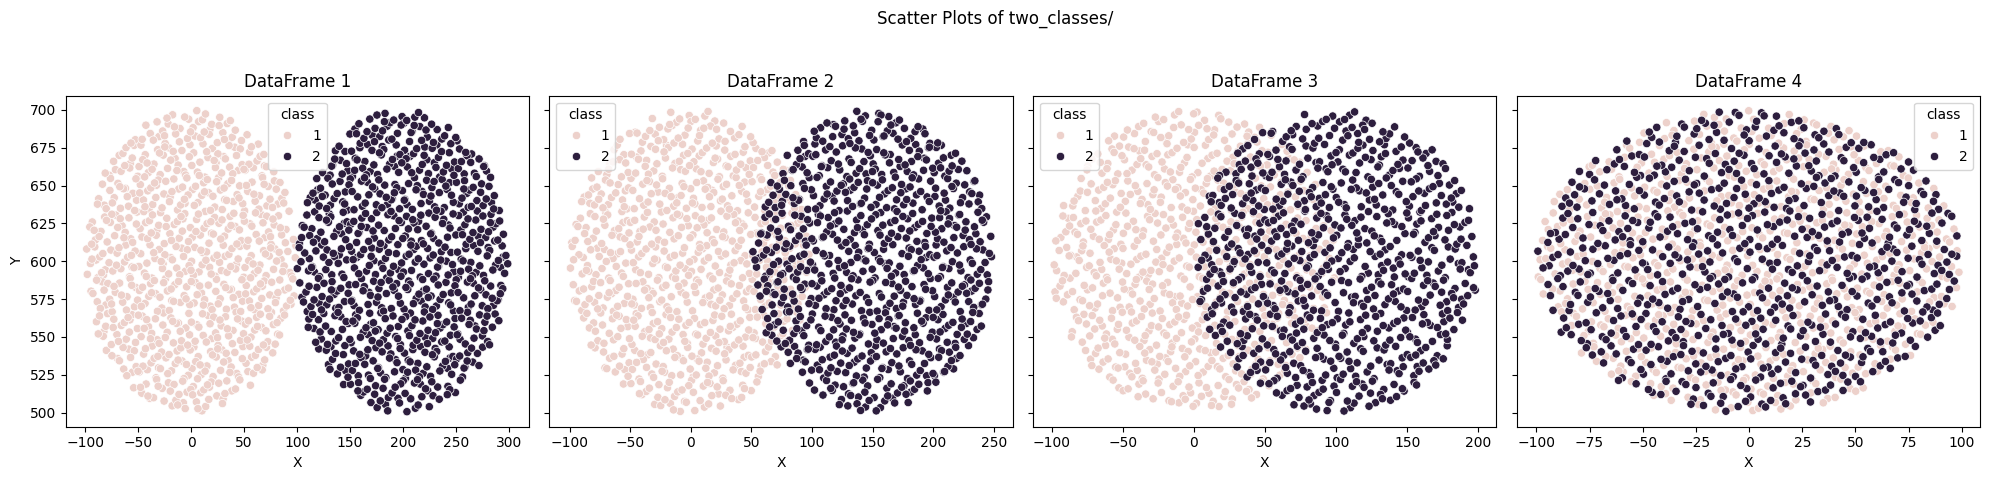

In [7]:
create_folder_plots("two_classes/")

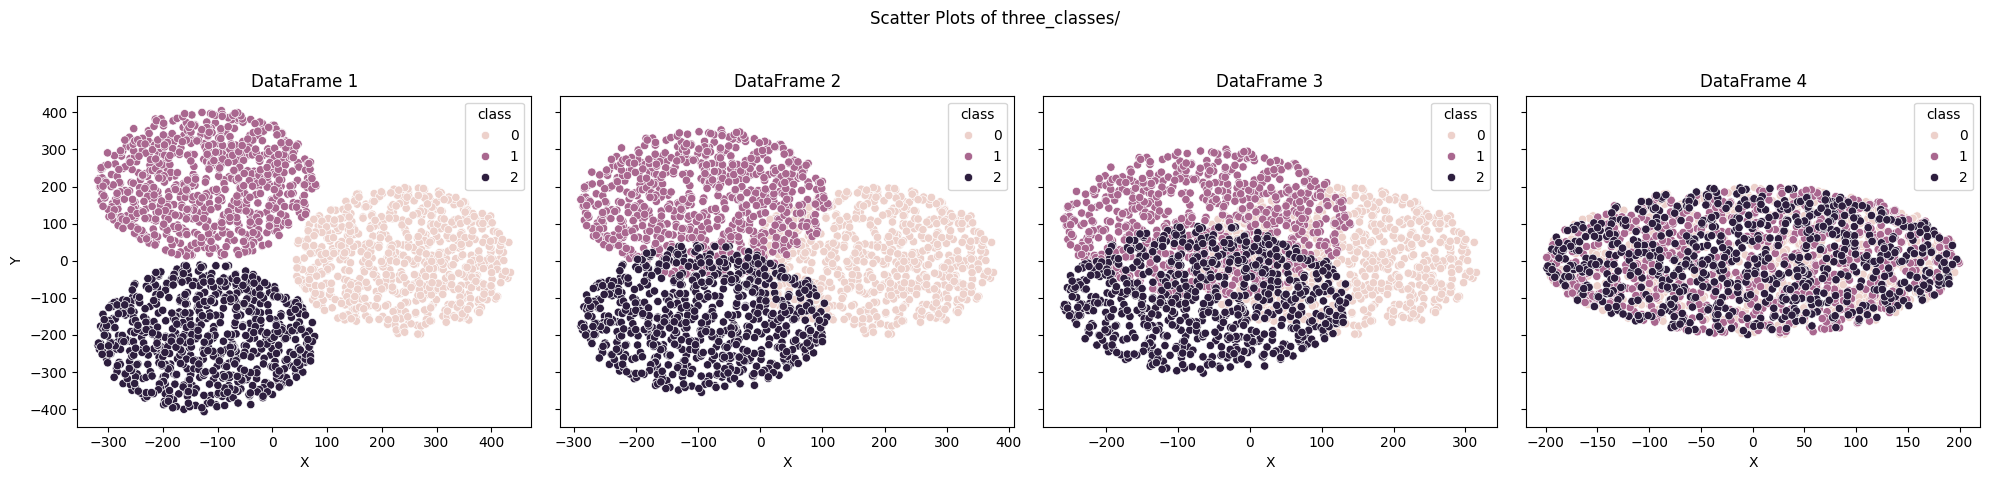

In [8]:
create_folder_plots("three_classes/")

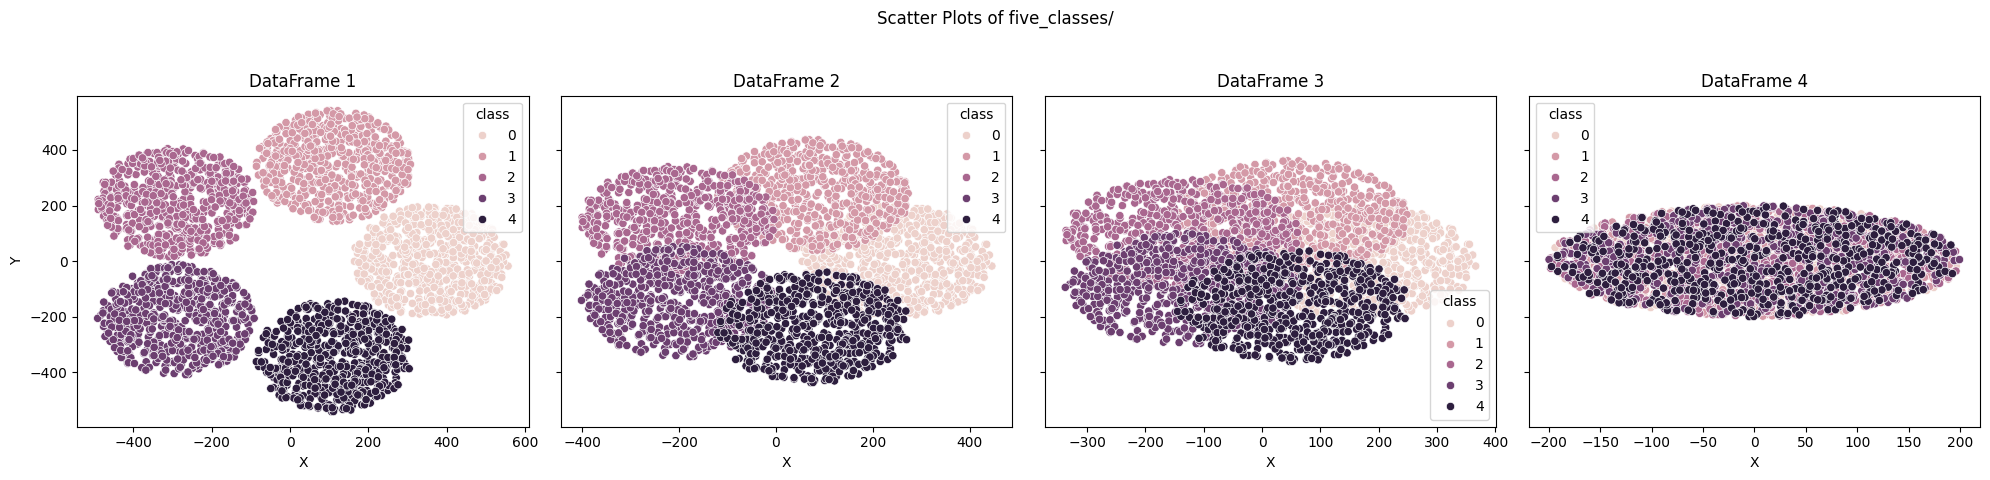

In [9]:
create_folder_plots("five_classes/")

In [10]:
feature_columns = ['X', 'Y']
label_column = 'class'

In [11]:
df2_1 = process_df(pd.read_csv('two_classes/results/test1_description_lenght_unnormalized.csv'))
df2_2 = process_df(pd.read_csv('two_classes/results/test2_description_lenght_unnormalized.csv'))
df2_3 = process_df(pd.read_csv('two_classes/results/test3_description_lenght_unnormalized.csv'))
df2_4 = process_df(pd.read_csv('two_classes/results/test4_description_lenght_unnormalized.csv'))

df3_1 = process_df(pd.read_csv('three_classes/results/test1_description_lenght_unnormalized.csv'))
df3_2 = process_df(pd.read_csv('three_classes/results/test2_description_lenght_unnormalized.csv'))
df3_3 = process_df(pd.read_csv('three_classes/results/test3_description_lenght_unnormalized.csv'))
df3_4 = process_df(pd.read_csv('three_classes/results/test4_description_lenght_unnormalized.csv'))

df5_1 = process_df(pd.read_csv('five_classes/results/test1_description_lenght_unnormalized.csv'))
df5_2 = process_df(pd.read_csv('five_classes/results/test2_description_lenght_unnormalized.csv'))
df5_3 = process_df(pd.read_csv('five_classes/results/test3_description_lenght_unnormalized.csv'))
df5_4 = process_df(pd.read_csv('five_classes/results/test4_description_lenght_unnormalized.csv'))


### Plotting Hardness

In [15]:
dfs_2 = [df2_1, df2_2, df2_3, df2_4]
dfs_3 = [df3_1, df3_2, df3_3, df3_4]
dfs_5 = [df5_1, df5_2, df5_3, df5_4]

#### r_min

In [ ]:
plot_hardness(dfs=dfs_2, hardness_measure='r_min', save_path='images/two_classes_r_min.png', show_plot=True)

In [ ]:
plot_hardness(dfs=dfs_3, hardness_measure='r_min', save_path='images/three_classes_r_min.png')

In [ ]:
plot_hardness(dfs=dfs_5, hardness_measure='r_min', show_plot=True), save_path='images/five_classes_r_min.png')

#### r_med

In [ ]:
plot_hardness(dfs=dfs_2, hardness_measure='r_med', save_path='images/two_classes_r_med.png')

In [ ]:
plot_hardness(dfs=dfs_3, hardness_measure='r_med', save_path='images/three_classes_r_med.png')

In [ ]:
plot_hardness(dfs=dfs_5, hardness_measure='r_med', save_path='images/five_classes_r_med.png')

#### relative_position

In [ ]:
plot_hardness(dfs=dfs_2, hardness_measure='relative_position', save_path='images/two_classes_relative_position.png')

In [ ]:
plot_hardness(dfs=dfs_3, hardness_measure='relative_position', save_path='images/three_classes_relative_position.png')

In [ ]:
plot_hardness(dfs=dfs_5, hardness_measure='relative_position', save_path='images/five_classes_relative_position.png')

#### pseudo_probability

In [ ]:
plot_hardness(dfs=dfs_2, hardness_measure='pseudo_probability', save_path='images/two_classes_pseudo_probability.png')

In [ ]:
plot_hardness(dfs=dfs_3, hardness_measure='pseudo_probability', save_path='images/three_classes_pseudo_probability.png')

In [ ]:
plot_hardness(dfs=dfs_5, hardness_measure='pseudo_probability', save_path='images/five_classes_pseudo_probability.png')

#### normalized_entropy

In [ ]:
plot_hardness(dfs=dfs_2, hardness_measure='normalized_entropy', save_path='images/two_classes_normalized_entropy.png')

In [ ]:
plot_hardness(dfs=dfs_3, hardness_measure='normalized_entropy', save_path='images/three_classes_normalized_entropy.png')

In [ ]:
plot_hardness(dfs=dfs_5, hardness_measure='normalized_entropy', save_path='images/five_classes_normalized_entropy.png')

#### description_lenght_margin

In [ ]:
plot_hardness(dfs=dfs_2, hardness_measure='description_lenght_margin', save_path='images/two_classes_description_lenght_margin.png')

In [ ]:
plot_hardness(dfs=dfs_3, hardness_measure='description_lenght_margin', save_path='images/three_classes_description_lenght_margin.png')

In [ ]:
plot_hardness(dfs=dfs_5, hardness_measure='description_lenght_margin', save_path='images/five_classes_description_lenght_margin.png')

#### description_lenght_true_cost

In [ ]:
plot_hardness(dfs=dfs_2, hardness_measure='description_lenght_true_cost', save_path='images/two_classes_description_lenght_true_cost.png')

In [ ]:
plot_hardness(dfs=dfs_3, hardness_measure='description_lenght_true_cost', save_path='images/three_classes_description_lenght_true_cost.png')

In [ ]:
plot_hardness(dfs=dfs_5, hardness_measure='description_lenght_true_cost', save_path='images/five_classes_description_lenght_true_cost.png')

#### kullback_leibler_divergence

In [ ]:
plot_hardness(dfs=dfs_2, hardness_measure='kullback_leibler_divergence', save_path='images/two_classes_kullback_leibler_divergence.png')

In [ ]:
plot_hardness(dfs=dfs_3, hardness_measure='kullback_leibler_divergence', save_path='images/three_classes_kullback_leibler_divergence.png')

In [ ]:
plot_hardness(dfs=dfs_5, hardness_measure='kullback_leibler_divergence', show_plot=True)#, save_path='images/five_classes_kullback_leibler_divergence.png')

### Quantitative Analysis

In [12]:
measure_cols = ['r_min', 'r_med', 'relative_position', 'pseudo_probability', 'normalized_entropy', 'description_lenght_margin', 'description_lenght_true_cost', 'kullback_leibler_divergence']

In [16]:
def plot_group_lineplot(dfs, measure_cols, group_name=None):
    
    difficulties = [1, 2, 3, 4]
    
    summary = []
    for diff, df in zip(difficulties, dfs):
        for col in measure_cols:
            summary.append({
                "difficulty": diff,
                "measure": col,
                "mean": df[col].mean(),
                "std": df[col].std()
            })
    
    summary_df = pd.DataFrame(summary)
    
    # plot
    plt.figure(figsize=(8, 5))
    for col in measure_cols:
        data = summary_df[summary_df["measure"] == col]
        
        plt.plot(data["difficulty"], data["mean"], marker="o", label=col)
        plt.fill_between(
            data["difficulty"], 
            data["mean"] - data["std"], 
            data["mean"] + data["std"], 
            alpha=0.2
        )
    
    plt.xticks(difficulties)
    plt.xlabel("Hardness Level")
    plt.ylabel("Mean")
    plt.title(f"Results - {group_name}" if group_name else "Results")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

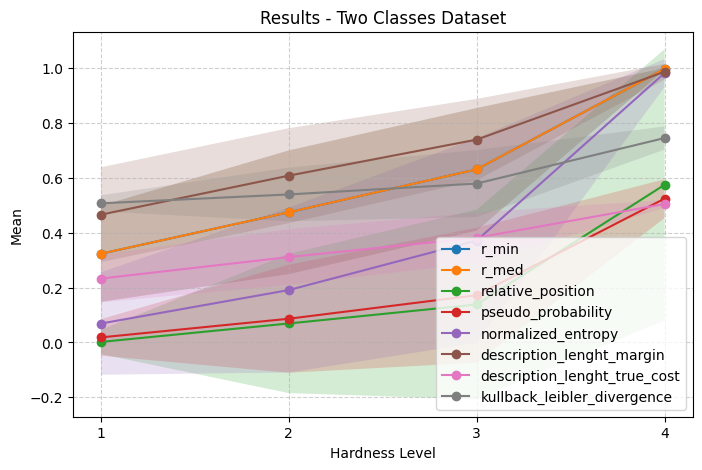

In [17]:
plot_group_lineplot(dfs_2, measure_cols, group_name="Two Classes Dataset")

In [18]:
from typing import List


def plot_groups_side_by_side(groups: List[List[pd.DataFrame]], measure_cols: List[str], output_path: str = None):
    difficulties = [1, 2, 3, 4]

    summaries = []
    for g_idx, dfs in enumerate(groups, start=1):
        summary = []
        for diff, df in zip(difficulties, dfs):
            for col in measure_cols:
                summary.append({
                    "group": f"Grupo {g_idx}",
                    "difficulty": diff,
                    "measure": col,
                    "mean": df[col].mean(),
                    "std": df[col].std()
                })
        summaries.append(pd.DataFrame(summary))

    n_measures = len(measure_cols)
    fig, axes = plt.subplots(len(groups), n_measures, 
                             figsize=(3*n_measures, 4*len(groups)), 
                             sharey=True)
    
    if len(groups) == 1:
        axes = [axes]

    for g_idx, summary_df in enumerate(summaries):
        for m_idx, col in enumerate(measure_cols):
            ax = axes[g_idx][m_idx] if len(groups) > 1 else axes[m_idx]

            data = summary_df[summary_df["measure"] == col]
            ax.plot(data["difficulty"], data["mean"], marker="o", label=col, color="C0")
            ax.fill_between(
                data["difficulty"],
                data["mean"] - data["std"],
                data["mean"] + data["std"],
                alpha=0.2,
                color="C0"
            )
            ax.set_xticks(difficulties)
            
            if g_idx == len(groups) - 1:  
                ax.set_xlabel("Hardness Level")
            if m_idx == 0:
                ax.set_ylabel("Mean")
            
            ax.set_title(col)

    plt.tight_layout()
    if output_path:
      plt.savefig(output_path)
    plt.show()

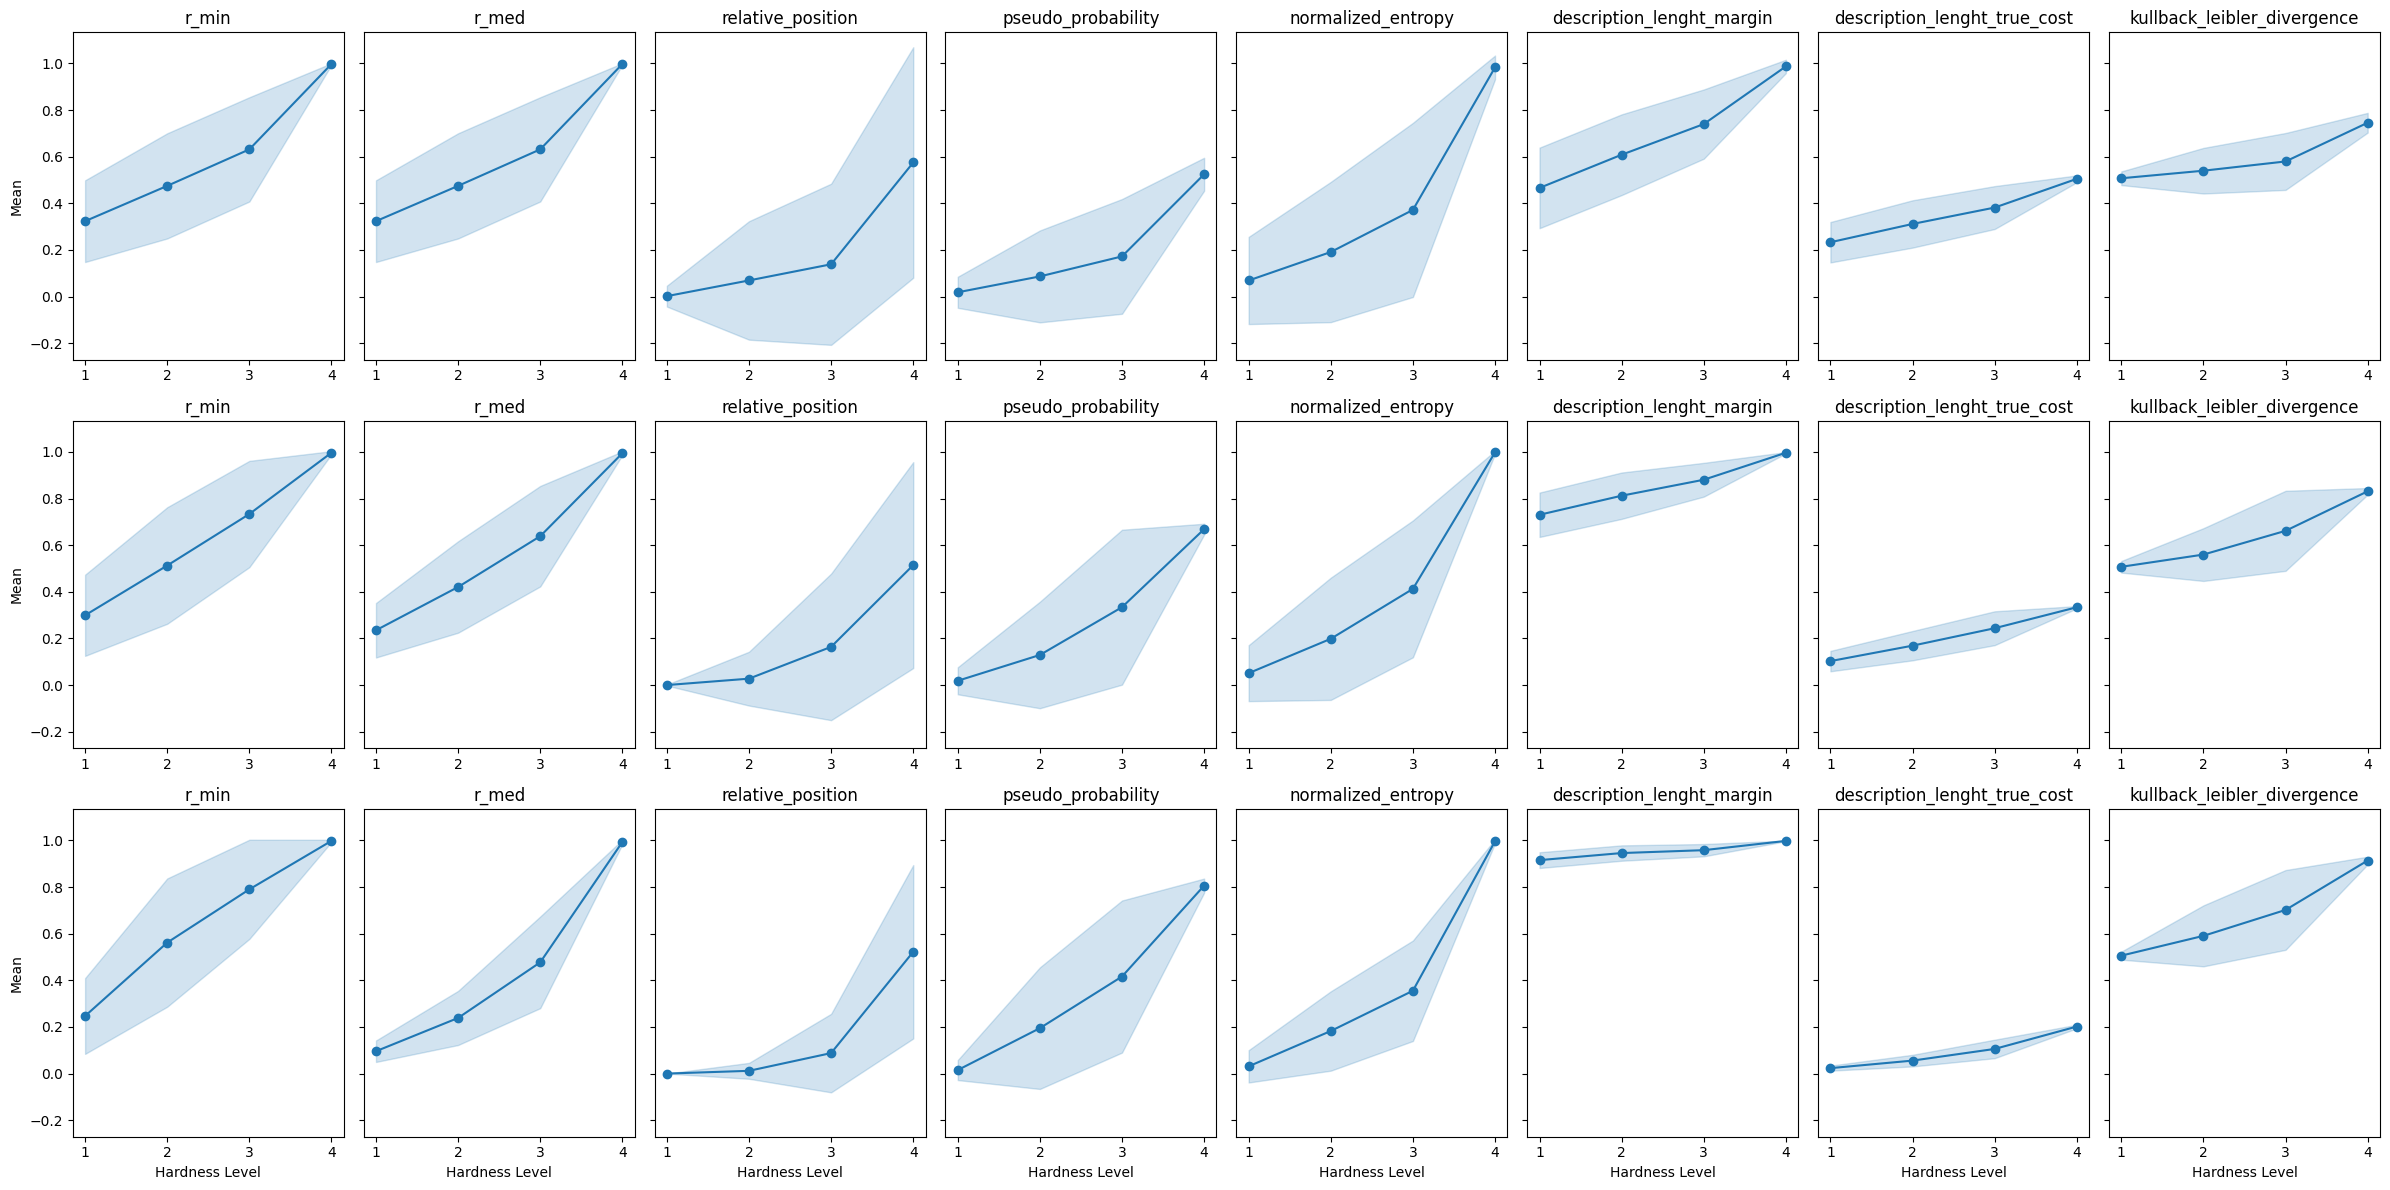

In [19]:
plot_groups_side_by_side([dfs_2, dfs_3, dfs_5], measure_cols, 'images/hardness_measures__mean_and_std.png')

In [20]:
def plot_distribution_by_error(dfs: List[pd.DataFrame], measure_cols: List[str], output_path: str = None):
    df_all = pd.concat(dfs, ignore_index=True)
    
    n_measures = len(measure_cols)
    fig, axes = plt.subplots(2, (n_measures + 1)//2, figsize=(4*(n_measures//2), 8))
    axes = axes.flatten()
    
    for i, col in enumerate(measure_cols):
        sns.violinplot(
            data=df_all, x="is_error", y=col, 
            ax=axes[i], palette="Set2", inner="box", hue="is_error"
        )
        axes[i].set_title(f"{col} distribution")
        axes[i].set_xlabel("is_error (0=ok, 1=error)")
        axes[i].set_ylabel(col)
    
    plt.tight_layout()
    if output_path:
      plt.savefig(output_path)
    plt.show()

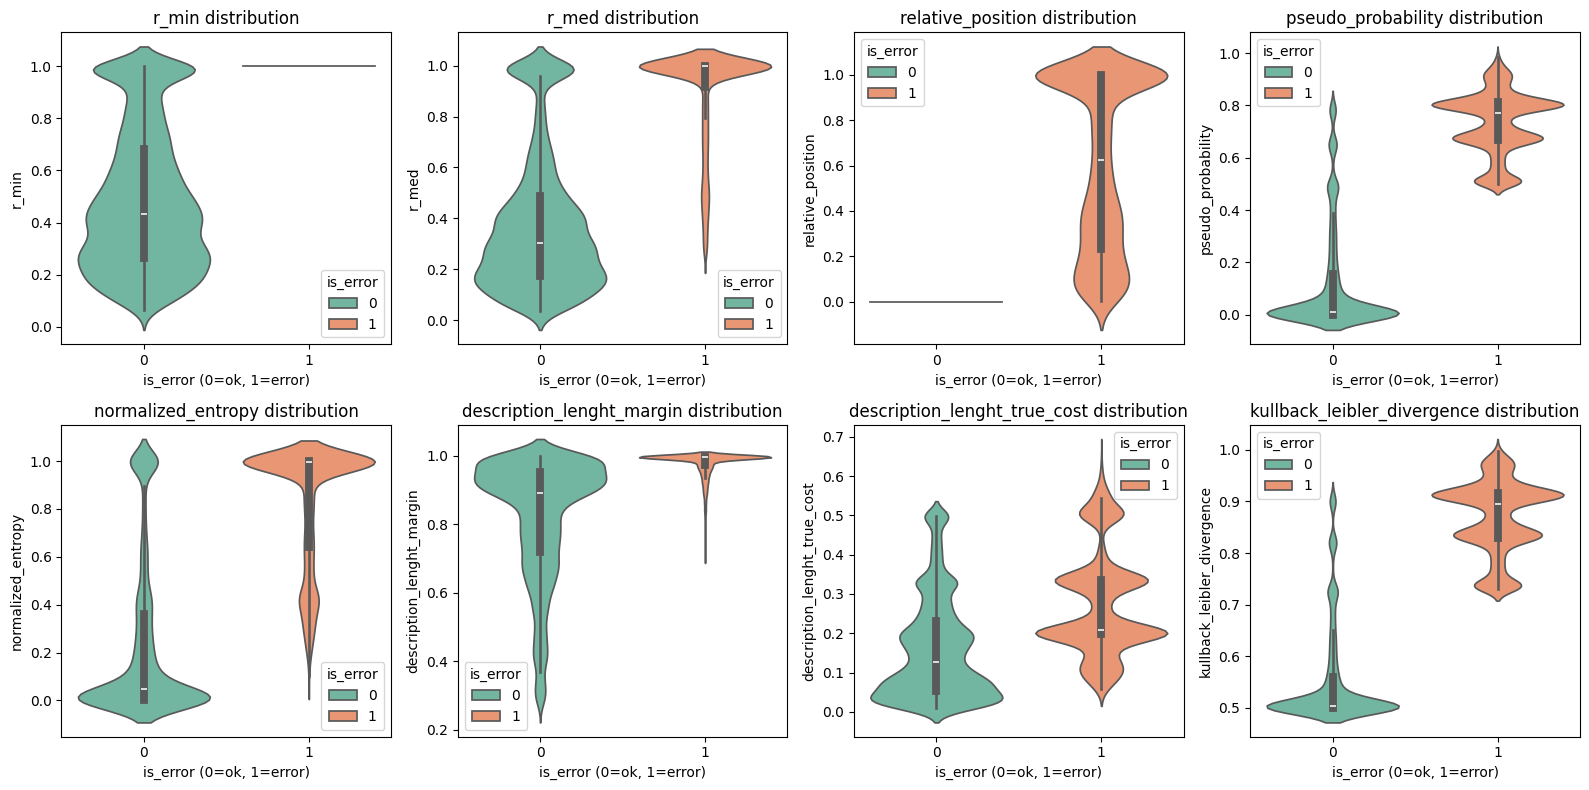

In [21]:
plot_distribution_by_error(dfs=dfs_2+dfs_3+dfs_5, measure_cols=measure_cols, output_path="images/hardness_measures__distribtion.png")

In [31]:
def plot_correlation_heatmap(df: pd.DataFrame, title: str = "corr", output_path: str = None, figsize=(10, 8)):
    corr = df.corr(method='kendall')

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8}
    )
    plt.title(title, fontsize=14)
    plt.tight_layout()
    if output_path:
      plt.savefig(output_path)
    plt.show()

In [32]:
all_dfs = dfs_2 + dfs_3 + dfs_5
df_all = pd.concat(all_dfs, ignore_index=True)
df_all_hardness = df_all[measure_cols+["is_error"]]

In [33]:
df_all_hardness.corr(method='spearman')

r_min     r_med  relative_position  \
r_min                         1.000000  0.893741           0.776900   
r_med                         0.893741  1.000000           0.713098   
relative_position             0.776900  0.713098           1.000000   
pseudo_probability            0.958578  0.839300           0.737677   
normalized_entropy            0.913685  0.884967           0.614665   
description_lenght_margin     0.766516  0.590495           0.553683   
description_lenght_true_cost  0.612695  0.845763           0.449261   
kullback_leibler_divergence   0.958554  0.839228           0.737677   
is_error                      0.791532  0.681555           0.981515   

                              pseudo_probability  normalized_entropy  \
r_min                                   0.958578            0.913685   
r_med                                   0.839300            0.884967   
relative_position                       0.737677            0.614665   
pseudo_probability                      1.000000            0.905027   
normalized_entropy                      0.905027            1.000000   
description_lenght_margin               0.793161            0.836765   
description_lenght_true_cost            0.498669            0.639406   
kullback_leibler_divergence             0.999997            0.905020   
is_error                                0.745998            0.606386   

                              description_lenght_margin  \
r_min                                          0.766516   
r_med                                          0.590495   
relative_position                              0.553683   
pseudo_probability                             0.793161   
normalized_entropy                             0.836765   
description_lenght_margin                      1.000000   
description_lenght_true_cost                   0.202433   
kullback_leibler_divergence                    0.793311   
is_error                                       0.566387   

                              description_lenght_true_cost  \
r_min                                             0.612695   
r_med                                             0.845763   
relative_position                                 0.449261   
pseudo_probability                                0.498669   
normalized_entropy                                0.639406   
description_lenght_margin                         0.202433   
description_lenght_true_cost                      1.000000   
kullback_leibler_divergence                       0.498492   
is_error                                          0.404554   

                              kullback_leibler_divergence  is_error  
r_min                                            0.958554  0.791532  
r_med                                            0.839228  0.681555  
relative_position                                0.737677  0.981515  
pseudo_probability                               0.999997  0.745998  
normalized_entropy                               0.905020  0.606386  
description_lenght_margin                        0.793311  0.566387  
description_lenght_true_cost                     0.498492  0.404554  
kullback_leibler_divergence                      1.000000  0.745998  
is_error                                         0.745998  1.000000

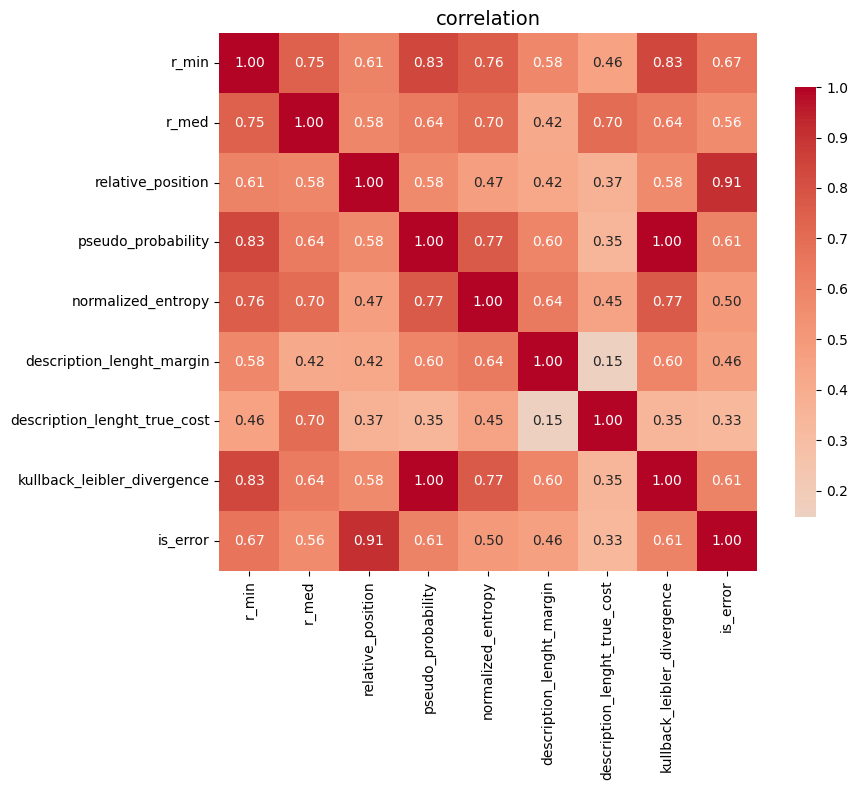

In [34]:
plot_correlation_heatmap(df=df_all_hardness, title="correlation", output_path="images/hardness_measures__correlation.png")

### PyHard vs HardnessMDL

In [35]:
df2_1_PyHard = pd.read_csv('two_classes/test1_PyHard.csv').drop(columns=['X', 'Y', 'class'])
df2_2_PyHard = pd.read_csv('two_classes/test2_PyHard.csv').drop(columns=['X', 'Y', 'class'])
df2_3_PyHard = pd.read_csv('two_classes/test3_PyHard.csv').drop(columns=['X', 'Y', 'class'])
df2_4_PyHard = pd.read_csv('two_classes/test4_PyHard.csv').drop(columns=['X', 'Y', 'class'])

df3_1_PyHard = pd.read_csv('three_classes/test1_PyHard.csv').drop(columns=['X', 'Y', 'class'])
df3_2_PyHard = pd.read_csv('three_classes/test2_PyHard.csv').drop(columns=['X', 'Y', 'class'])
df3_3_PyHard = pd.read_csv('three_classes/test3_PyHard.csv').drop(columns=['X', 'Y', 'class'])
df3_4_PyHard = pd.read_csv('three_classes/test4_PyHard.csv').drop(columns=['X', 'Y', 'class'])

df5_1_PyHard = pd.read_csv('five_classes/test1_PyHard.csv').drop(columns=['X', 'Y', 'class'])
df5_2_PyHard = pd.read_csv('five_classes/test2_PyHard.csv').drop(columns=['X', 'Y', 'class'])
df5_3_PyHard = pd.read_csv('five_classes/test3_PyHard.csv').drop(columns=['X', 'Y', 'class'])
df5_4_PyHard = pd.read_csv('five_classes/test4_PyHard.csv').drop(columns=['X', 'Y', 'class'])


In [36]:
df_all_PyHard = pd.concat([df2_1_PyHard, df2_2_PyHard, df2_3_PyHard, df2_4_PyHard, df3_1_PyHard, df3_2_PyHard, df3_3_PyHard, df3_4_PyHard, df5_1_PyHard, df5_2_PyHard, df5_3_PyHard, df5_4_PyHard], 
                          ignore_index=True)

In [37]:
pd.concat([df_all_hardness, df_all_PyHard], axis=1).columns

Index(['r_min', 'r_med', 'relative_position', 'pseudo_probability',
       'normalized_entropy', 'description_lenght_margin',
       'description_lenght_true_cost', 'kullback_leibler_divergence',
       'is_error', 'feature_kDN', 'feature_DS', 'feature_DCP', 'feature_TD_P',
       'feature_TD_U', 'feature_CL', 'feature_CLD', 'feature_MV', 'feature_CB',
       'feature_N1', 'feature_N2', 'feature_LSC', 'feature_LSR',
       'feature_Harmfulness', 'feature_Usefulness', 'feature_F1', 'feature_F2',
       'feature_F3', 'feature_F4', 'instance_hardness'],
      dtype='object')

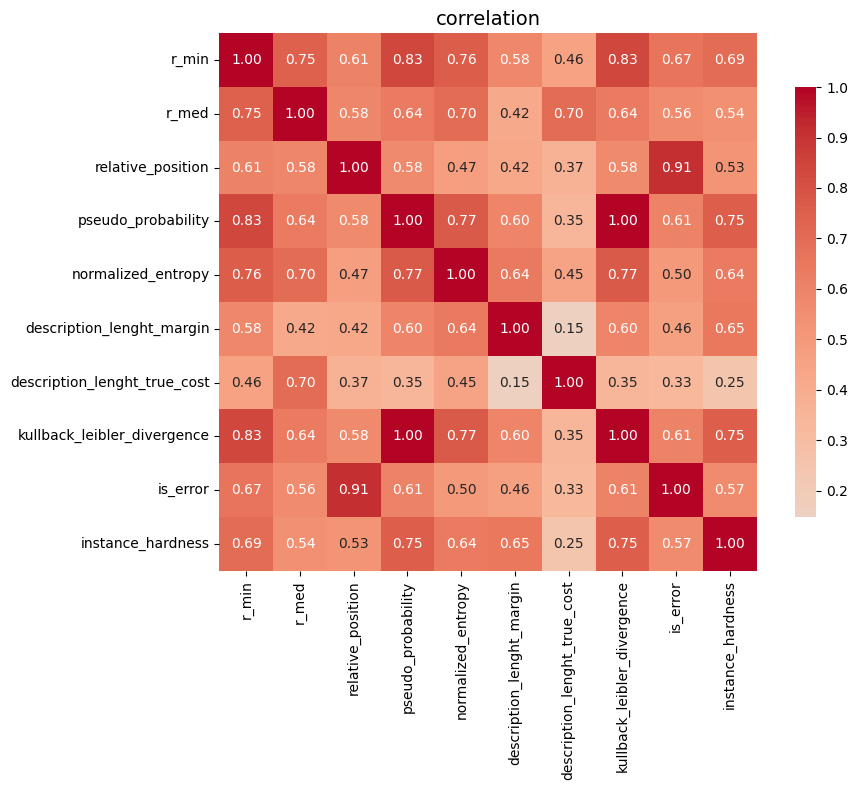

In [38]:
df_hardnessmdl_instancehardness = pd.concat([df_all_hardness, df_all_PyHard.instance_hardness], axis=1)
plot_correlation_heatmap(df=df_hardnessmdl_instancehardness, title="correlation", output_path="images/hardness_measures__pyhard_instance_hardness.png")

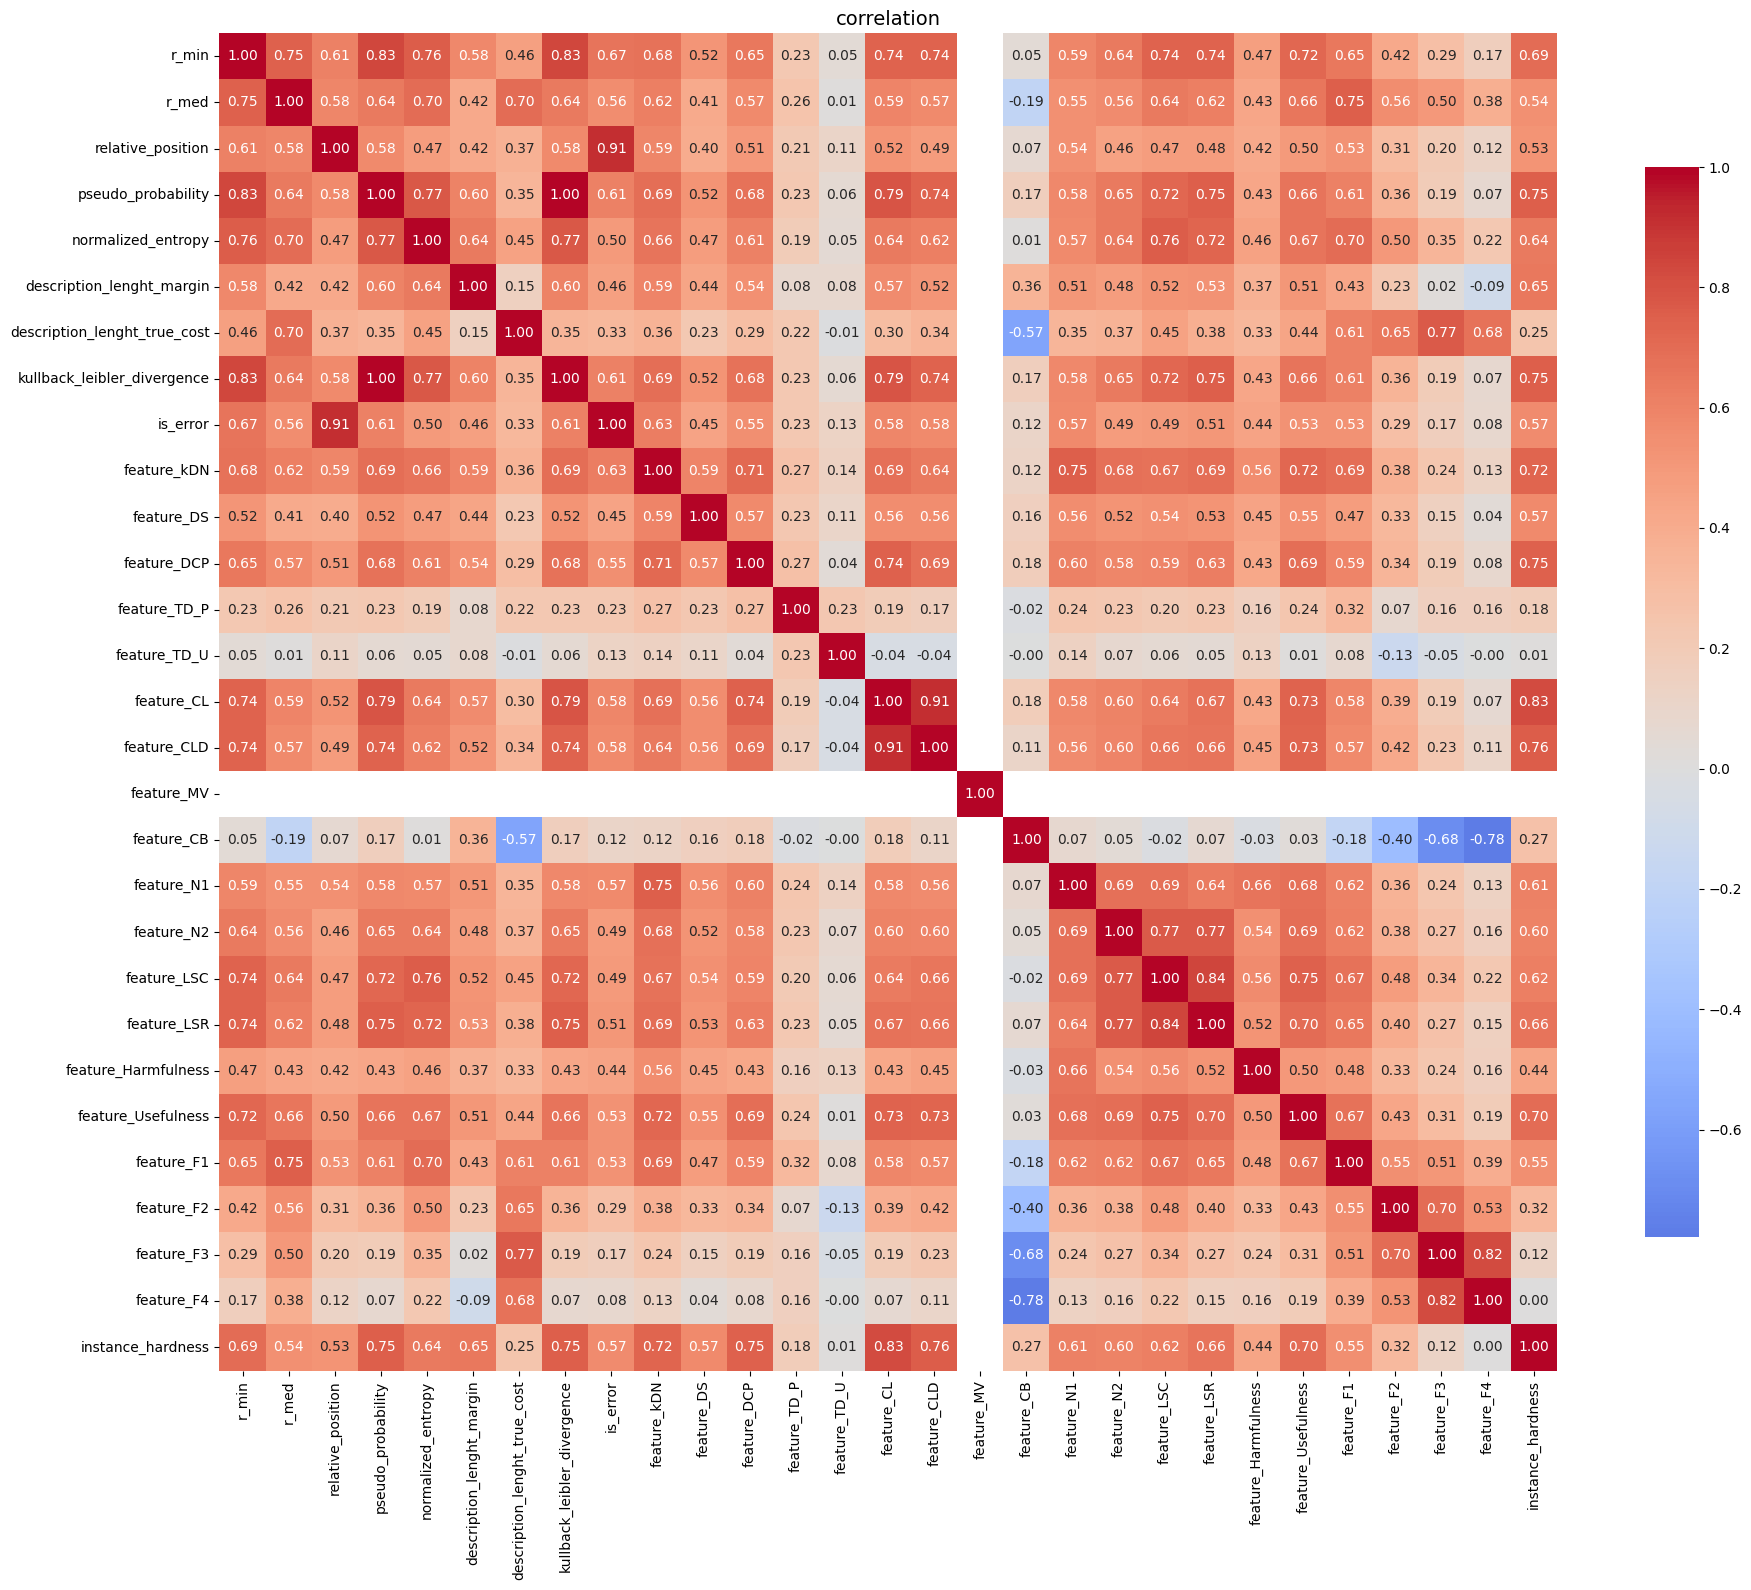

In [39]:
df_hardnessmdl_pyhard = pd.concat([df_all_hardness, df_all_PyHard], axis=1)
plot_correlation_heatmap(df=df_hardnessmdl_pyhard, title="correlation", output_path="images/hardness_measures__pyhard_correlation.png", figsize=(20, 16))
